## Effect Size Simulations

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import *
from time import time

In [2]:
def pooled_sd(arr1, arr2):
    n1 = len(arr1)
    n2 = len(arr2)
    sd1 = np.std(arr1)
    sd2 = np.std(arr2)
    return (((n1 - 1)*sd1**2 + (n2-1)*sd2**2) / (n1 + n2-2))**0.5

In [3]:
def get_bootstrap_indices(arr, n=1000, sample_size=None):
    if sample_size is None:
        sample_size = len(arr)
    return np.random.choice(np.arange(len(arr)), size=[sample_size,n], replace=True)

def bootstrap_samples(y_pred, y_true=None, n=1000, sample_size=None):
    indices = get_bootstrap_indices(y_pred, n=n, sample_size=sample_size)
    out = {'y_pred_bootstrap': y_pred[indices]}
    if y_true is not None:
        out['y_true_bootstrap'] = y_true[indices]
    return out

def apply_fun(bootstrap_samples, fun, requires_y_true=True):
    if requires_y_true:
        zipped = zip(bootstrap_samples['y_true_bootstrap'].T, 
                     bootstrap_samples['y_pred_bootstrap'].T)
        return np.array([fun(true, pred) for true, pred in zipped])
    else:
        return np.array([fun(s) for s in bootstrap_samples['y_pred_bootstrap'].T])

def cohens_d(arr1, arr2, verbose=False):
    if verbose:
        print(f'Mean Statistic 1: {np.mean(arr1)}', 
              f'Mean Statistic 2: {np.mean(arr2)}')
    return (np.mean(arr1)-np.mean(arr2)) / pooled_sd(arr1, arr2)

def compare(samples1, samples2, fun, requires_y_true=None, verbose=True):
    if requires_y_true is None:
        requires_y_true = False
        if 'y_true_bootstrap' in samples1:
            requires_y_true = True
    out1 = apply_fun(samples1, fun, requires_y_true)
    out2 = apply_fun(samples2, fun, requires_y_true)
    out = cohens_d(out1, out2, verbose=verbose)
    return out

## Simulation 1

In [36]:
dist1 = lambda size: np.random.normal(loc=2, 
                                      scale=1, 
                                      size=size)
dist2 = lambda size: np.random.normal(loc=0, 
                                      scale=1, 
                                      size=size)
val1 = dist1(10000)
val2 = dist2(10000)

### simple case - calculate whether distributions are different

* Sample each distribution N times
* calculate the effect size between the two distributions
* this gives you CI around the effect size

Text(0.5, 1.0, '1.9913268785654676')

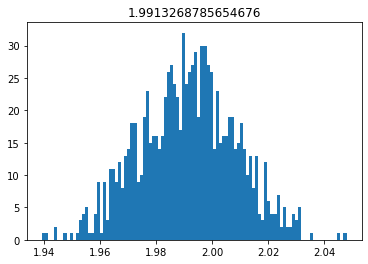

In [37]:
samples1 = bootstrap_samples(val1, sample_size=None)
samples2 = bootstrap_samples(val2, sample_size=None)

tmp1 = samples1['y_pred_bootstrap']
tmp2 = samples2['y_pred_bootstrap']

effect_sizes = [cohens_d(tmp1[:,i], tmp2[:, i]) for i in range(tmp1.shape[1])]
h=plt.hist(effect_sizes, bins=100)
plt.title(np.mean(effect_sizes))

### What if each sample just gave one number? Like the accuracy

In this case, you calculate the statistic for each sample. For instance, let's say we get correct or incorrect values for each person and want to see if the overall accuracy differs between groups. We can use the bootstrap to get a distribution of accuracies for each sample. We can compare the two distributions of accuracy, but the distributions move towards a point estimate as the sample size goes up! If we use the original sample sizes we will always get a humongous effect size! This is kind of how it should be however, because ...stats.

A proper bootstrap will use the same N as the original example. Otherwise you will underestimate the effect size. But maybe we can use that to our advantage...

First, let's go through the normal stuff.

In [144]:
# parameteric, classic stats with a sample of 100
def to_observations(binomial_results):
    N = sum(binomial_results)
    return [N, len(binomial_results)-N]

def calc_statistic(p1, p2, n1, n2):
    p_combined = (p1*n1+p2*n2)/(n1+n2)
    z = (p1-p2)/(p_combined*(1-p_combined)*(1/n1+1/n2))**.5
    p_val = stats.norm.sf(abs(z))*2
    return z, p_val

repeats = []
for _ in range(100):
    val1 = dist1(100)
    val2 = dist2(100)
    # chisquared test
    results = {}
    out = stats.chi2_contingency([to_observations(val1), to_observations(val2)])
    results['chi_sq'] = out[1]

    # another test
    # see here https://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other
    p1 = np.mean(val1)
    p2 = np.mean(val2)
    n1 = len(val1)
    n2 = len(val2)
    z, p_val = calc_statistic(p1, p2, n1, n2)
    results['z_test'] = p_val
    repeats.append(results)

Text(0.5, 1.0, '0.21329845762009186')

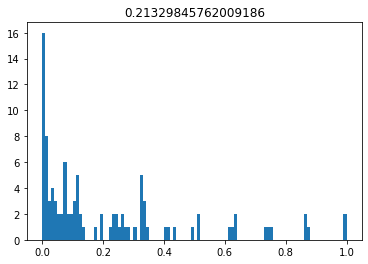

In [145]:
# we get a range of p vals for each sample
statistics = [r['z_test'] for r in repeats]
_=plt.hist(statistics, bins=100)
plt.title(np.mean(statistics))

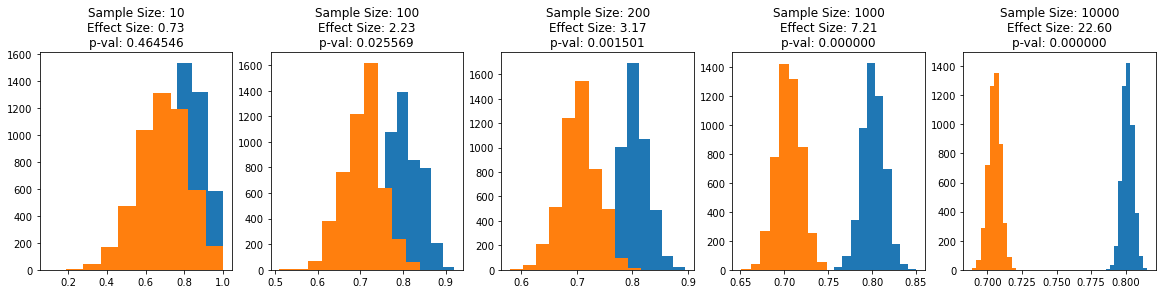

In [164]:
# we can also estimate these p values using the bootstrap. Or just the effect size. Who needs p-vals anyway?
val1 = dist1(10000)
val2 = dist2(10000)
n=5000
sample_sizes = [10, 100, 200, 1000, None]
h= f, axes = plt.subplots(1,len(sample_sizes), figsize=(len(sample_sizes)*4,4))

for ax, sample_size in zip(axes, sample_sizes):
    sample1 = bootstrap_samples(val1, n=n, sample_size=sample_size)
    sample2 = bootstrap_samples(val2, n=n, sample_size=sample_size)
    N = len(sample1['y_pred_bootstrap']) # sample size
    statistic1 = np.mean(sample1['y_pred_bootstrap'], axis=0)
    statistic2 = np.mean(sample2['y_pred_bootstrap'], axis=0)

    effect_size = cohens_d(statistic1, statistic2)
    p_val = stats.norm.sf(abs(effect_size))*2
    ax.hist(statistic1)
    ax.hist(statistic2)
    ax.set_title(f'Sample Size: {N}\nEffect Size: {effect_size:.2f}\np-val: {p_val:f}')


In [140]:
calc_statistic(.2, .3, 100, 100)

-1.6329931618554518

So what does this mean? Well let's say you want think an "accuracy difference of 10% is a big deal"... Well, actually that's not gonna be good enough as a difference in accuracy between 40% and 50% is less impressive than 85% and 95%. So let's be more precise with our example. You think: "if one group has an accuracy of 80%, the other group haven't more than 10% difference is a big deal". Let's turn that into code.

Let's assume both have the same sample size for the purpose of this translation. That means we can combine n1 and n2

In [174]:
def calc_statistic(p1, p2, n1, n2):
    p_combined = (p1*n1+p2*n2)/(n1+n2)
    z = (p1-p2)/(p_combined*(1-p_combined)*(1/n1+1/n2))**.5
    p_val = stats.norm.sf(abs(z))*2
    return z, p_val

def calc_statistic(p1, p2, n):
    p_combined = (p1+p2)/2
    z = (p1-p2)/(p_combined*(1-p_combined)*(2/n))**.5
    p_val = stats.norm.sf(abs(z))*2
    return z, p_val

we can solve for z...

In [181]:
def find_n(p1, p2, test_statistic):
    p_combined = (p1+p2)/2
    num = p_combined*(1-p_combined)*2
    denom = ((p1-p2)/test_statistic)**2
    return num/denom


In [202]:
# set up the analogy
base=.8
significant_accuracy_diff = .1
p1 = significant_accuracy_diff+base
p2 = base

# define what "very important". Let's say "very important" means a p-val of .01
important_p_val = .01
sig_val = stats.norm.ppf(1-important_p_val/2) # zval equal to pval of .05
n = find_n(p1, p2, sig_val)
print(f'Number of people to use for this test: {n}')

Number of people to use for this test: 169.18986332604092


Now we have an N. We can use this in the bootstrap for random other metrics and give "practically significant" results. "Practical significance" is defined as "statistical significance" with the number of people we found above.

We can imagine giving a short questionnaire (like a investment company does - see vanguard). The questionnaire would give a few examples like above and we would get samples of their "risk tolerance". We then apply that to any metric.

## Simulation - Regression

So now let's say we have a real use case. We have two distributions and our "predictive model" is worse on one than another. The way it's worse is its predictions are "noisier" (we've added a certain amount of gaussian noise). Is the difference between the two models "bad"?

In [240]:
#config
dist1 = lambda size: np.random.exponential(size=size)
n1 = 10000
n2 = 10000
true1, true2 = dist1(n1), dist1(n2)
noise1 = .4
noise2 = .6

pred1 = true1 + np.random.normal(size=n1)*noise1
pred2 = true2 + np.random.normal(size=n2)*noise2


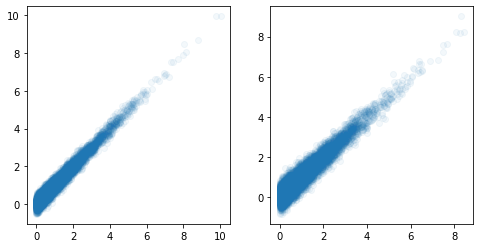

In [241]:
f, axes = plt.subplots(1,2, figsize=(8,4))
axes[0].scatter(true1, pred1, alpha=.05)
axes[1].scatter(true2, pred2, alpha=.05)

### First Sim

Text(0.5, 1.0, 'Good?: NO\nSample Size: 169\nEffect Size: 3.15\np-val: 0.001620')

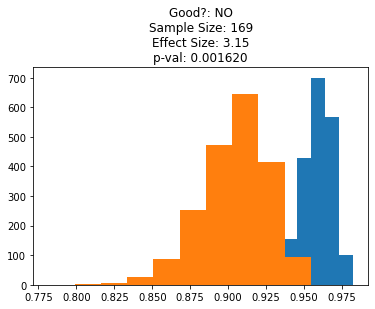

In [243]:
# do the bootstrap
n_boot = 2000
sample_size=int(n)
samples1 = bootstrap_samples(pred1, true1, 
                             n_boot, sample_size=sample_size)
samples2 = bootstrap_samples(pred2, true2, 
                             n_boot, sample_size=sample_size)
# on each sample compute r2_score
fun = r2_score
requires_y_true = True
statistic1 = apply_fun(samples1, fun, requires_y_true)
statistic2 = apply_fun(samples2, fun, requires_y_true)

# compare distributions of r2 scores
effect_size = cohens_d(statistic1, statistic2)
p_val = stats.norm.sf(abs(effect_size))*2
answer = 'YES' if p_val > .01 else 'NO'
plt.hist(statistic1)
plt.hist(statistic2)
plt.title(f'Good?: {answer}/nSample Size: {sample_size}\nEffect Size: {effect_size:.2f}\np-val: {p_val:f}')

# Scrap

### First Sim

In [297]:
pred1 = true1 + np.random.normal(size=n1)*.4
pred2 = true2 + np.random.normal(size=n2)*.5

n_boot = 2000
sample_size=1000
samples1 = bootstrap_samples(pred1, true1, 
                             n_boot, sample_size=sample_size)
samples2 = bootstrap_samples(pred2, true2, 
                             n_boot, sample_size=sample_size)

fun = r2_score
requires_y_true = True
out1 = apply_fun(samples1, fun, requires_y_true)
out2 = apply_fun(samples2, fun, requires_y_true)

Text(0.5, 1.0, '3.766937991050949, 0.029009527929095235')

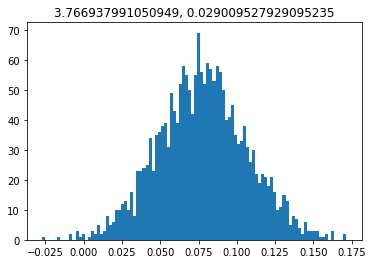

In [298]:
dist = out1-out2
_ = plt.hist(dist, bins=100)
plt.title(f'{cohens_d(out1, out2)}, {np.std(dist)}')

In [308]:
from scipy.stats import norm
abs(norm.ppf(.001))/10000**.5

0.03090232306167813

In [314]:
# convert effect sizes into needed sample size to discover at .05
effects = [0.01, .05, .1] # small, medium, large
p_val = .05
sample_sizes = [(abs(norm.ppf(p_val))/e)**2 for e in effects]
sample_sizes

[27055.434540954146, 1082.2173816381658, 270.55434540954144]

### First Sim

In [297]:
pred1 = true1 + np.random.normal(size=n1)*.4
pred2 = true2 + np.random.normal(size=n2)*.5

n_boot = 2000
sample_size=1000
samples1 = bootstrap_samples(pred1, true1, 
                             n_boot, sample_size=sample_size)
samples2 = bootstrap_samples(pred2, true2, 
                             n_boot, sample_size=sample_size)

fun = r2_score
requires_y_true = True
out1 = apply_fun(samples1, fun, requires_y_true)
out2 = apply_fun(samples2, fun, requires_y_true)

Text(0.5, 1.0, '3.766937991050949, 0.029009527929095235')

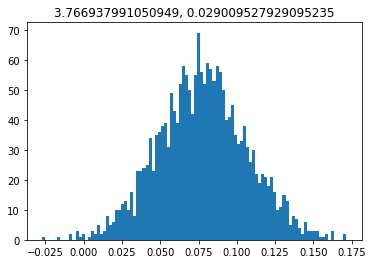

In [298]:
dist = out1-out2
_ = plt.hist(dist, bins=100)
plt.title(f'{cohens_d(out1, out2)}, {np.std(dist)}')

In [308]:
from scipy.stats import norm
abs(norm.ppf(.001))/10000**.5

0.03090232306167813

In [314]:
# convert effect sizes into needed sample size to discover at .05
effects = [0.01, .05, .1] # small, medium, large
p_val = .05
sample_sizes = [(abs(norm.ppf(p_val))/e)**2 for e in effects]
sample_sizes

[27055.434540954146, 1082.2173816381658, 270.55434540954144]

### More parameters

In [236]:
def evaluate(pred1, true1, pred2, true2, n=1000, sample_size=None):
    samples1 = bootstrap_samples(pred1, true1, 1000, sample_size=sample_size)
    samples2 = bootstrap_samples(pred2, true2, 1000, sample_size=sample_size)
    effect_size = compare(samples1, samples2, r2_score, verbose=False)
    return effect_size

In [235]:
noises = np.arange(0,1, .05)

In [9]:
# full sample
start = time()
results = []
for comparison_noise in noises:
    pred1 = true1 + np.random.normal(size=n1)*.4
    pred2 = true2 + np.random.normal(size=n2)*comparison_noise
    results.append(evaluate(pred1, true1, pred2, true2))
full_boot = pd.Series(results, index=noises, name='full')
full_time = time()-start

NameError: name 'samples' is not defined

In [ ]:
series = []
times = []
sample_sizes = np.arange(100,5000, 500)
for sample_size in sample_sizes:
    results = []
    start = time()
    for comparison_noise in noises:
        pred1 = true1 + np.random.normal(size=n1)*.4
        pred2 = true2 + np.random.normal(size=n2)*comparison_noise
        results.append(evaluate(pred1, true1, pred2, true2, sample_size=sample_size))
    series.append(pd.Series(results, index=noises, name=sample_size))
    times.append(time()-start)

In [ ]:
df = pd.concat(series + [full_boot], axis=1)

In [ ]:
df.plot()

In [ ]:
# time taken
pd.Series([full_time] + times, index= ['full'] + list(sample_sizes))